# Estudo de Ciencia de Dados para usando o GapMinder

- Separação de dados em níveis de qualidade de dados (bronze, prata, ouro)
- Uso de backward-fill e interpolação linear para preenchimento de dados vazios


Fontes de Dados
- Consumo de proteína: https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Daily%20protein%20supply%20-%20FAO%20(2017)/Daily%20protein%20supply%20-%20FAO%20(2017).csv
- Letramento: https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Cross-country%20literacy%20rates%20-%20World%20Bank%2C%20CIA%20World%20Factbook%2C%20and%20other%20sources/Cross-country%20literacy%20rates%20-%20World%20Bank%2C%20CIA%20World%20Factbook%2C%20and%20other%20sources.csv


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO

df = pd.read_csv('dados/bronze/gapminder_full.csv', sep=',')

## Descrições Iniciais do Dataset - Sem limpeza

In [2]:
df.head()

,country,year,pop,continent,lifeExp,gdpPercap
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1736 non-null   object 
 1   year       1736 non-null   int64  
 2   pop        1736 non-null   float64
 3   continent  1736 non-null   object 
 4   lifeExp    1736 non-null   float64
 5   gdpPercap  1736 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 81.5+ KB


In [4]:
df.describe()

,year,pop,lifeExp,gdpPercap
count,1736.000000,1.736000e+03,1736.000000,1736.000000
mean,1979.669931,3.156800e+07,59.511979,7240.155986
std,17.296364,1.172888e+08,12.956028,9839.873695
min,1952.000000,6.001100e+04,23.599000,241.165876
25%,1967.000000,2.818694e+06,48.245000,1202.060309
50%,1982.000000,7.150606e+06,60.808000,3534.772106
75%,1997.000000,1.977102e+07,70.945000,9380.254270
max,2007.000000,1.318683e+09,82.603000,113523.132900


## Análise de limpeza dos dataset

In [5]:
size_country = df.groupby("country").size().sort_values(ascending=False)
size_country

country
France      19
Bolivia     17
Guinea      17
Ecuador     15
China       15
            ..
Germany     12
Gambia      12
Gabon       12
Finland     12
Zimbabwe    12
Length: 142, dtype: int64

Temos valores duplicados em nosso dataset...

In [6]:
df = df.drop_duplicates(subset=['country', 'year'])
df = df.drop_duplicates() # para outros casos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1704 entries, 0 to 1735
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1704 non-null   object 
 1   year       1704 non-null   int64  
 2   pop        1704 non-null   float64
 3   continent  1704 non-null   object 
 4   lifeExp    1704 non-null   float64
 5   gdpPercap  1704 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 93.2+ KB


Foram removidos 32 registros duplicados...

Agora queremos verificar se os registros por ano estão distribuídos uniformente

In [7]:
df_analise_agrupamento_anoxpais = df.sort_values(["country", "year"])
df_analise_agrupamento_anoxpais["diff_ano"] = df.groupby("country")["year"].diff().fillna(0).astype(int)
df_analise_agrupamento_anoxpais

,country,year,pop,continent,lifeExp,gdpPercap,diff_ano
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,0
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,5
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,5
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,5
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,5
...,...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,5
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,5
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,5
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,5


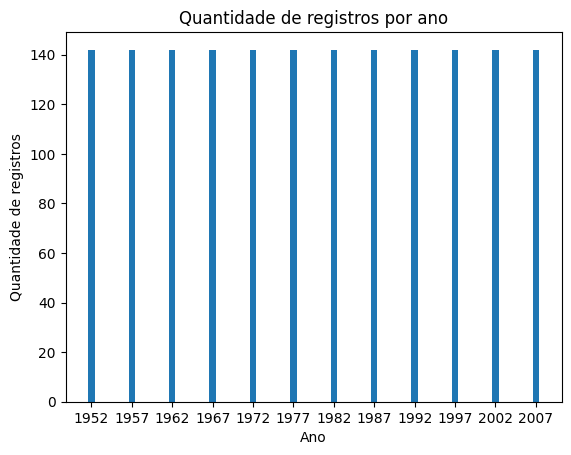

In [8]:
count_por_ano = df_analise_agrupamento_anoxpais.groupby("year").size().reset_index(name="total")
plt.figure()
plt.bar(count_por_ano["year"], count_por_ano["total"])
plt.xlabel("Ano")
plt.ylabel("Quantidade de registros")
plt.title("Quantidade de registros por ano")
plt.xticks(count_por_ano["year"])
plt.show()

Os registros estão distribuídos uniformemente com registros a cada 5 anos... 

Verificando existência de dados ausentes

In [9]:
df.isnull().sum()

country      0
year         0
pop          0
continent    0
lifeExp      0
gdpPercap    0
dtype: int64

Não há nenhum dado ausente em nosso data set - vamos salvar uma versão limpa dos dados

In [10]:
df.to_csv("dados/prata/gapminder_dataset_limpo.csv", sep='\t', encoding='utf-8')

## Criando novas colunas - derivando dados

In [11]:
df["gdp_total"] = df["pop"] * df["gdpPercap"]
df["gdp_total_bn"] = df["gdp_total"] / 1_000_000_000
df["pop_mn"] = df["pop"] / 1_000_000
df

,country,year,pop,continent,lifeExp,gdpPercap,gdp_total,gdp_total_bn,pop_mn
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,6.567086e+09,6.567086,8.425333
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,7.585449e+09,7.585449,9.240934
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,8.758856e+09,8.758856,10.267083
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,9.648014e+09,9.648014,11.537966
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,9.678553e+09,9.678553,13.079460
...,...,...,...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,6.508241e+09,6.508241,9.216418
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,7.422612e+09,7.422612,10.704340
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,9.037851e+09,9.037851,11.404948
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,8.015111e+09,8.015111,11.926563


## Obtendo dados de fontes externas

In [ ]:
def load_csv_columns(url, path, columns):
    response = requests.get(url)
    response.raise_for_status()
    result = pd.read_csv(StringIO(response.text))
    _result = result[columns].reset_index(drop=True)
    result.to_csv(path, sep=';', encoding='utf-8', index=False)
    return _result

def preencher_dataframe_por_interpolacao_linear(dataframe):
    dataframe = dataframe.sort_values("year")
    anos_completos = pd.DataFrame({
        "year": range(dataframe["year"].min(), dataframe["year"].max() + 1)
    })
    dataframe = anos_completos.merge(dataframe, on="year", how="left")
    dataframe["country"] = dataframe["country"].ffill().bfill()
    dataframe["child_mortality"] = (
        dataframe["child_mortality"]
        .interpolate(method="linear")
        .bfill()
    )
    return dataframe  

### Código ISO dos Países (Chave Primária para outros datasets)

In [58]:
iso_countries = load_csv_columns(
    "https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv", 
    "dados/bronze/contry_iso_codes.csv", 
    ["COUNTRY", "CODE"]
)

iso_countries = iso_countries.rename(columns={
    "COUNTRY": "country",
    "CODE": "code"
})

child_mortality = load_csv_columns(
    "https://raw.githubusercontent.com/owid/owid-datasets/6155d4ca1ea14ef30e753010a25521eeb416e8a2/datasets/Child%20mortality%20-%20Gapminder%20(2013)/Child%20mortality%20-%20Gapminder%20(2013).csv",
    "dados/bronze/child_mortality.csv",
    ["Entity", "Year", "Child mortality (Gapminder (2013))"]
)

child_mortality = child_mortality.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Child mortality (Gapminder (2013))" : "child_mortality"
})

child_mortality = preencher_dataframe_por_interpolacao_linear(child_mortality).sort_values(by=['country', 'year'])

child_mortality = (
    child_mortality
    .groupby("country", group_keys=False)
    .apply(preencher_dataframe_por_interpolacao_linear)
    .sort_values(["country", "year"])
    .reset_index(drop=True)
)

child_mortality.to_csv("dados/prata/child_mortality.csv", sep=';', encoding='utf-8', index=False)

co2_share = load_csv_columns(
    "https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Cumulative%20CO2%20emissions%20share%20(OWID%20based%20on%20GCP%2C%202017)/Cumulative%20CO2%20emissions%20share%20(OWID%20based%20on%20GCP%2C%202017).csv",
    "dados/bronze/co2_emissions.csv",
    ["Entity", "Year", "Cumulative CO2 emissions share (OWID based on GCP, 2017)"]
)

co2_share = co2_share.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Cumulative CO2 emissions share (OWID based on GCP, 2017)" : "co2_share"
})

co2_share.to_csv("dados/prata/co2_emissions.csv", sep=';', encoding='utf-8', index=False)

literacy = load_csv_columns(
    "https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Cross-country%20literacy%20rates%20-%20World%20Bank%2C%20CIA%20World%20Factbook%2C%20and%20other%20sources/Cross-country%20literacy%20rates%20-%20World%20Bank%2C%20CIA%20World%20Factbook%2C%20and%20other%20sources.csv",
    "dados/bronze/literacy_rate.csv",
    ["Entity", "Year", "Literacy rates (World Bank, CIA World Factbook, and other sources)"]
)

literacy = literacy.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Literacy rates (World Bank, CIA World Factbook, and other sources)" : "literacy_rate"
})

literacy[literacy["year"] < 2007].value_counts(["year"])


/var/folders/h5/yg4dz5cd3rsb_l6l7lxylhpr0000gn/T/ipykernel_54671/1991363091.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(preencher_dataframe_por_interpolacao_linear)


year
2000    84
1990    52
2004    34
2003    34
1980    34
2001    33
2006    26
1991    26
1981    26
1970    25
1979    25
1930    22
1950    22
1940    22
2002    22
1920    22
2005    21
1960    21
1975    20
1900    20
1910    20
1976    20
1974    15
1973    15
1972    15
1971    15
1977    14
1978    14
1994    14
1989    13
1982    11
1999    10
1750    10
1996    10
1650    10
1992    10
1475    10
1550    10
1870     8
1985     8
1984     7
1820     7
1987     6
1998     6
1988     6
1995     6
1986     6
1983     5
1993     5
1997     4
1880     2
1890     2
1969     2
1959     1
1952     1
1947     1
Name: count, dtype: int64

In [49]:
#df_code = df.merge(iso_countries[["code", "country"]], on=["country"], how="left")
df_cm = df.merge(child_mortality[["child_mortality", "year", "country"]], on=["country", "year"], how="left")
df_cm = df.merge(co2_share[["co2_share", "year", "country"]], on=["country", "year"], how="left")
df_cm.to_csv("dados/ouro/dados_consolidados.csv", sep=';', encoding='utf-8', index=False)
df_cm

,country,year,pop,continent,lifeExp,gdpPercap,gdp_total,gdp_total_bn,pop_mn,co2_share
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,6.567086e+09,6.567086,8.425333,0.0001
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,7.585449e+09,7.585449,9.240934,0.0004
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,8.758856e+09,8.758856,10.267083,0.0011
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,9.648014e+09,9.648014,11.537966,0.0022
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,9.678553e+09,9.678553,13.079460,0.0034
...,...,...,...,...,...,...,...,...,...,...
1699,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,6.508241e+09,6.508241,9.216418,0.0450
1700,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,7.422612e+09,7.422612,10.704340,0.0486
1701,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,9.037851e+09,9.037851,11.404948,0.0509
1702,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,8.015111e+09,8.015111,11.926563,0.0514


# Opções - Mundial

- Fazer a linha média mundial de alguma coisa e a linha média por país
- Países com maior crescimento de expectativa de vida no periodo (Por década)
- Países com maior decrescimo de expectativa de vida no periodo (Por década)
- Análise de Tendência de expectativa de vida mundial
- Análise por continente
- Top 10


# Brasil
- Análise de tendência de expectativa de vida (Precisa complementar os dados)
- Análise de tentência de crescimento de PIB (Precisa complementar os dados)
- Correlação entre crescimento do emprego com a expectativa de vida

- derivar variaveis